In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# Print the shape of the training and testing datasets
print("Training dataset shape:", len(train_loader.dataset), len(test_loader.dataset))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:33<00:00, 293019.39it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 66454.30it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:07<00:00, 226462.67it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Training dataset shape: 60000 10000


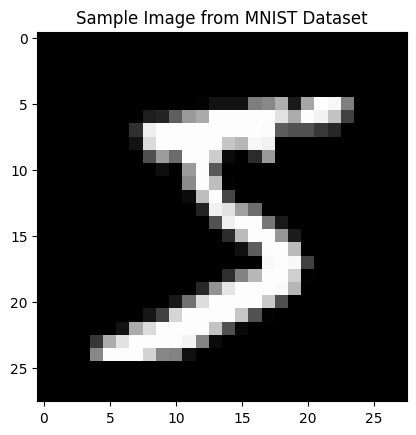

In [3]:
# Plot a sample image from the training dataset
plt.imshow(train_loader.dataset.data[0].numpy().reshape(28, 28), cmap='gray')
plt.title("Sample Image from MNIST Dataset")
plt.show()

In [4]:
# Find unique labels
unique_labels = np.unique(train_loader.dataset.targets.numpy())
print("Unique labels:", unique_labels)

Unique labels: [0 1 2 3 4 5 6 7 8 9]


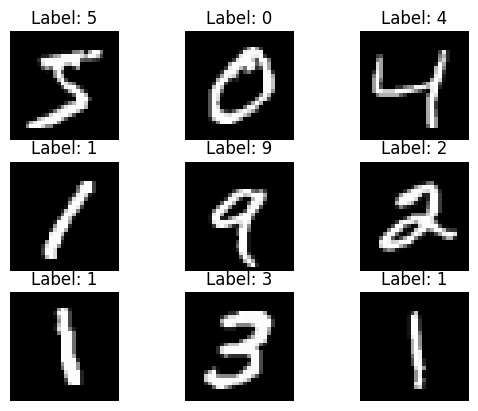

In [5]:
# Display 9 images from the training dataset with their labels
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_loader.dataset.data[i].numpy().reshape(28, 28), cmap='gray')
    plt.title(f"Label: {train_loader.dataset.targets.numpy()[i]}")
    plt.axis('off')

plt.show()

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        x = self.softmax(x)
        return x

In [7]:
# Initialize the model, loss function, and optimizer
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [13]:
from tqdm import tqdm
# Train the model
for epoch in range(10):
    train_loss, correct = 0, 0
    with tqdm(train_loader, desc=f"Epoch {epoch+1}") as pbar:
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.view(-1, 784), target
            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

Epoch 10: 100%|█████████████████████████████████████████████████████████| 469/469 [00:21<00:00, 22.20it/s, loss=1.5549]


In [9]:
# Evaluate the model
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.view(-1, 784), target
        output = net(data)
        test_loss += criterion(output, target).item()
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()

accuracy = correct / len(test_loader.dataset)
print(f'Test accuracy: {accuracy:.2f}%')

Test accuracy: 0.97%


In [10]:
y_pred = []
y_test = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.view(-1, 784), target
        output = net(data)
        pred = output.max(1, keepdim=True)[1]
        y_pred.extend(pred.numpy().flatten())
        y_test.extend(target.numpy())

In [11]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

accuracy = np.sum(np.diag(cm)) / np.sum(cm)
precision = np.diag(cm) / np.sum(cm, axis=0)
recall = np.diag(cm) / np.sum(cm, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1_score)

Accuracy: 0.9691
Precision: [0.96517413 0.98941799 0.97070312 0.94913628 0.93792435 0.97597254
 0.98083067 0.97647059 0.97563559 0.97061803]
Recall: [0.98979592 0.98854626 0.96317829 0.97920792 0.98472505 0.95627803
 0.96137787 0.9688716  0.94558522 0.94945491]
F1-Score: [0.97732997 0.98898193 0.96692607 0.96393762 0.96075509 0.96602492
 0.97100685 0.97265625 0.96037539 0.95991984]


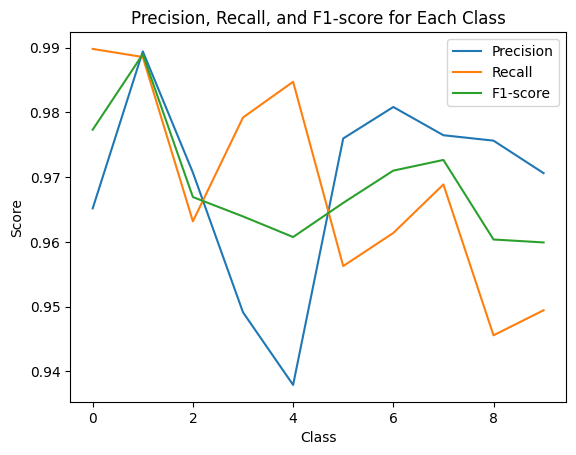

In [12]:
plt.plot(precision, label='Precision')
plt.plot(recall, label='Recall')
plt.plot(f1_score, label='F1-score')
plt.title('Precision, Recall, and F1-score for Each Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.legend()
plt.show()